$Dirichlet$ $Process$ Demo

Import modules

In [1]:
import numpy as np
import numpy.linalg as lg
import matplotlib.pyplot as plt
from collections.abc import Iterable

Define a prior distribution (base distribution $H$), and use Monte Carlo to sample a few distributions

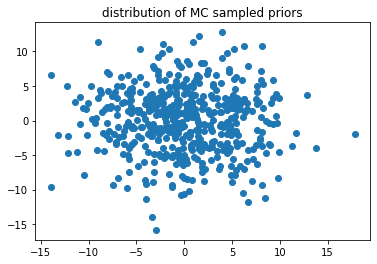

In [2]:
prior_amount = 512 # number of sampled priors
np.random.seed(123)

# prior sampling
row_xy = np.random.uniform(-0.99, 0.99, prior_amount)
mu_x, mu_y = np.random.normal(0, 5, (2, prior_amount))
sigma_x, sigma_y = np.random.uniform(0.5, 1, (2, prior_amount))
inverse_matrices = np.zeros((prior_amount, 2, 2))

inverse_matrices[:, 0, 0] = sigma_x**2
inverse_matrices[:, 1, 1] = sigma_y**2
inverse_matrices[:, 0, 1] = row_xy*sigma_x*sigma_y
inverse_matrices[:, 1, 0] = row_xy*sigma_x*sigma_y

inverse_matrices[:] = lg.inv(inverse_matrices[:])
mu = np.zeros((prior_amount, 2), dtype=np.float32)
mu[:, 0] = mu_x
mu[:, 1] = mu_y

plt.scatter(mu_x, mu_y)
plt.title("distribution of MC sampled priors")
plt.show()

All we need about the prior sampling is to ensure a good coverage of prior distributions.

Now we generate the data, the data distribution is a mixture of Gaussians, consisting of 6 clusters.

The mixture components are sampled from the prior (assumed by the Dirichlet Process theory).

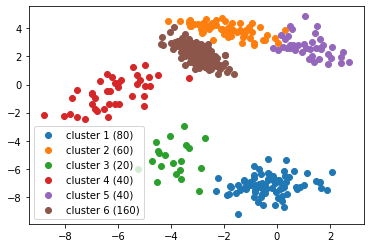

In [3]:
# data generation, 6 clusters
np.random.seed(111)
total_data_size = 400

selected_index = set()

row_xy_data = np.random.uniform(-0.99, 0.99, 6)
mu_x_data, mu_y_data = np.random.normal(0, 5, (2, 6))
sigma_x_data, sigma_y_data = np.random.uniform(0.5, 1, (2, 6))


p = (0.2, 0.15, 0.05, 0.1, 0.1, 0.4)

total_data = np.zeros((total_data_size, 2), dtype=np.float32)
cumulated_size = 0

visualize = True


for i in range(6):
    data_size = int(p[i] * total_data_size)
    data_x = np.random.normal(mu_x_data[i], sigma_x_data[i], data_size)
    data_y = np.random.normal(mu_y_data[i] + row_xy_data[i]*sigma_y_data[i]/sigma_x_data[i]*(data_x - mu_x_data[i]),
                              sigma_y_data[i]*np.sqrt(1 - row_xy_data[i]**2), data_size)

    if visualize:
        plt.scatter(data_x, data_y, label=f"cluster {i+1} ({data_size})")

    total_data[cumulated_size: cumulated_size+data_size, 0] = data_x
    total_data[cumulated_size: cumulated_size+data_size, 1] = data_y
    cumulated_size += data_size


if visualize:
    plt.legend()
    plt.show()

We have sampled 400 data, coming from six clusters. Some of those clusters are well-separated, some are not.

Now we define the Experience class, Cluster class and Archive class. The Experience in this case is the same as data.

We implement the Gibbs sampling as a function of Archive obj. Calling it will sweep through all the Experieneces once. 

In [4]:
# no need to understand how it works in detail ...
class Experience:
    def __init__(self, data):
        self.data = data.reshape(-1, 2)
        power =  (self.data - mu[:, None, :]) @ inverse_matrices @ (self.data.T - mu[:, :, None])

        self.log_likelihoods = -0.5*power[:, 0, 0] - np.log(sigma_x*sigma_y*np.sqrt(1 - row_xy**2))
        self.id = 0
        self.cluster_id = 0



class Cluster:
    def __init__(self, ids, archive, threshold=30):
        self.id = 0
        self.threshold = threshold
        self.archive = archive
        if isinstance(ids, int):
            self.members = {ids: archive.experiences[ids]}
        else:
            self.members = {}
            for id in ids:
                self.members[id] = archive.experiences[id]
        
        self.log_likelihoods = np.zeros(prior_amount, dtype=np.float32)
        self.weights = np.zeros(prior_amount, dtype=np.float32)
        self.size = len(self.members)
        self.mean = np.zeros((1, 2), dtype=np.float32)
        self.inverse_covariance = np.zeros((2, 2), dtype=np.float32)
        self.det = 1
    

    def update(self):
        self.size = len(self.members)
        if self.size == 0:
            return False

        if self.size >= self.threshold:
            data = np.zeros((self.size, 2), dtype=np.float32)
            for index, exp in enumerate(self.members.values()):
                data[index] = exp.data
            
            self.mean[0, :] = np.mean(data, axis=0)
            cov = np.cov(data.T)
            self.det = lg.det(cov)
            self.inverse_covariance[:, :] = lg.inv(cov)
        else:
            log_likelihoods = np.zeros(prior_amount, dtype=np.float32)
            for member in self.members.values():
                log_likelihoods += member.log_likelihoods
            self.log_likelihoods[:] = log_likelihoods
            log_likelihoods -= np.max(log_likelihoods)
            weights = np.exp(log_likelihoods)
            weights /= np.sum(weights)
            self.weights[:] = weights
        return True


    def eval_prob(self, id):
        exp = self.archive.experiences[id]
        if self.size >= self.threshold:
            data = exp.data
            if id in self.members:
                likelihood = self.size - 1
                mean = (self.mean * self.size - data) / (self.size - 1)
                log_factor = -0.5*(data - mean) @ self.inverse_covariance @ (data - mean).T - 0.5*np.log(self.det)
            else:
                likelihood = self.size
                log_factor = -0.5*(data - self.mean) @ self.inverse_covariance @ (data - self.mean).T - 0.5*np.log(self.det)
        else:
            log_factor = np.max(exp.log_likelihoods)
            if id in self.members:
                if self.size == 1:
                    return 0, None
                log_likelihood = self.log_likelihoods - exp.log_likelihoods
                weights = np.exp(log_likelihood - np.max(log_likelihood))
                weights /= np.sum(weights)
                likelihood = np.sum(weights * np.exp(exp.log_likelihoods - log_factor)) * (self.size - 1)
            else:
                likelihood = np.sum(self.weights * np.exp(exp.log_likelihoods - log_factor)) * self.size

        return log_factor, likelihood
    


class Archive:
    def __init__(self, alpha):
        self.alpha = alpha # concentration parameter
        self.experiences = {}
        self.empty_exp_id = []
        self.next_exp_id = 1

        self.clusters = {}
        self.empty_cluster_id = []
        self.next_cluster_id = 1
    

    def read_experiences(self, exps):
        if not isinstance(exps, Iterable):
            exps = (exps,)

        for exp in exps:
            if self.empty_exp_id:
                id = self.empty_exp_id[0]
                self.empty_exp_id.remove(id)
            else:
                id = self.next_exp_id
                self.next_exp_id += 1
            
            exp.id = id
            self.experiences[id] = exp
            exp.cluster_id = self.generate_cluster(id)
    

    def generate_cluster(self, ids):
        if self.empty_cluster_id:
            id = self.empty_cluster_id[0]
            self.empty_cluster_id.remove(id)
        else:
            id = self.next_cluster_id
            self.next_cluster_id += 1
        
        cluster = Cluster(ids, self)
        cluster.id = id
        self.clusters[id] = cluster
        self.update_cluster(id)
        return id


    def update_cluster(self, id):
        exist = self.clusters[id].update()
        if not exist:
            self.remove_cluster(id)


    def remove_exp(self, id):
        del self.experiences[id] # unregister this experience
        self.empty_exp_id.append(id) # record this empty id 


    def remove_cluster(self, id):
        del self.clusters[id] # unregister this cluster
        self.empty_cluster_id.append(id) # record this empty id 


    def gibbs_loop(self):
        for exp_id, exp in self.experiences.items():
            likelihoods = np.zeros(len(self.clusters)+1, dtype=np.float32)
            log_factors = np.zeros(len(self.clusters)+1, dtype=np.float32)
            cluster_ids = np.zeros(len(self.clusters)+1, dtype=np.int32)

            log_factors[:] = np.max(exp.log_likelihoods)
            exp_likelihoods = np.exp(exp.log_likelihoods - np.max(exp.log_likelihoods))
            likelihoods[0] = np.mean(exp_likelihoods) * self.alpha 

            for index, (cluster_id, cluster) in enumerate(self.clusters.items()):
                cluster_ids[index+1] = cluster_id
                log_factor, likelihood = cluster.eval_prob(exp_id)

                if likelihood is None:
                    likelihoods[index+1] = likelihoods[0]
                    likelihoods[0] = 0
                else:
                    likelihoods[index+1] = likelihood 
                    log_factors[index+1] = log_factor

            likelihoods *= np.exp(log_factors - np.max(log_factors))
            likelihoods /= np.sum(likelihoods)
            
            selected_cluster = cluster_ids[np.random.choice(len(self.clusters)+1, p=likelihoods)]
            if selected_cluster and selected_cluster != exp.cluster_id:
                new_cluster = self.clusters[selected_cluster]
                old_cluster = self.clusters[exp.cluster_id]

                new_cluster.members[exp_id] = exp
                self.update_cluster(selected_cluster)

                del old_cluster.members[exp_id]
                self.update_cluster(exp.cluster_id)

                exp.cluster_id = selected_cluster
            elif selected_cluster == 0:
                old_cluster = self.clusters[exp.cluster_id]
                del old_cluster.members[exp_id]
                self.update_cluster(exp.cluster_id)
                exp.cluster_id = self.generate_cluster(exp_id)
            

We follow the theory of $Dirichlet$ $Process$, assuming the data distribution $G$ we have is a latent model:

$$ G \sim DP(H, \alpha) $$

Where the $\alpha$ is the concentration parameter. In Gibbs sampling this controls the generation of new cluster.

We first suffle the data, and input the data as mini batches (20 at a time). Each time we input the data, we conduct 10 Gibbs sweeps.

In [5]:
archive = Archive(alpha=1.0) # The only imput of Archive obj is the concentration parameter.

np.random.seed(123)
np.random.shuffle(total_data)

batch_num = 20
batch_size = int(total_data_size / batch_num)
iteration = 10
for batch in range(batch_num):
    exps = [Experience(data) for data in total_data[batch*batch_size: batch*batch_size+batch_size]]
    archive.read_experiences(exps)
    for i in range(iteration):
        archive.gibbs_loop()


print()
size = 0
for i, j in enumerate(archive.clusters.values(), 1):
    print(f"Cluster {i}: ", f"size = {len(j.members)}")
    size += j.size


print("\n", "Total size:", size)



Cluster 1:  size = 156
Cluster 2:  size = 79
Cluster 3:  size = 67
Cluster 4:  size = 9
Cluster 5:  size = 13
Cluster 6:  size = 5
Cluster 7:  size = 40
Cluster 8:  size = 11
Cluster 9:  size = 14
Cluster 10:  size = 3
Cluster 11:  size = 3

 Total size: 400


we then do 100 sweeps at the end, try to ensure the convergence.

In [6]:
iter = 100
for i in range(iter):
    archive.gibbs_loop()
    
    if (i+1) % 10 == 0:
        print(f"iter {1+i}:", "Cluster num", len(archive.clusters))


iter 10: Cluster num 10
iter 20: Cluster num 9
iter 30: Cluster num 9
iter 40: Cluster num 8
iter 50: Cluster num 8
iter 60: Cluster num 9
iter 70: Cluster num 10
iter 80: Cluster num 10
iter 90: Cluster num 8
iter 100: Cluster num 9


We filter out the clusters whose sizes are smaller than 10 and plot out the result.

Cluster 0, size = 156
Cluster 1, size = 81
Cluster 2, size = 39
Cluster 3, size = 13
Cluster 4, size = 40
Cluster 5, size = 54


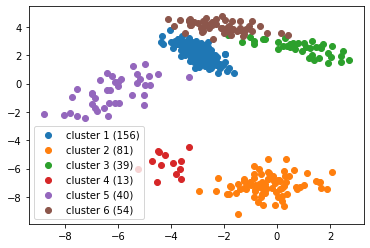

In [8]:
cluster_index = 0
for i, j in archive.clusters.items():
    if j.size > 10:
        print(f"Cluster {cluster_index}, size = {j.size}")
        cluster_index += 1
        xy = np.zeros((j.size, 2))
        for index, exp in enumerate(j.members.values()):
            xy[index, :] = exp.data[0]

        plt.scatter(xy.T[0], xy.T[1], label=f"cluster {cluster_index} ({j.size})")
plt.legend()
plt.show()

We see that it sucessfully recovers our initial input clustering. Althrough it may confuse the data at the overlapping areas of clusters, and it may create undesired small clusters.

But the oevrall pattern is satisfying. Note that we have not informed it with the number of clusters we need, it figured out by itself.

Running it with a different randon seed may give slightly different result. Sometimes the top-right clusters are merged, sometimes are separated.